In [1]:
using Dates: DateTime, @dateformat_str
using CSV, DataFrames, LaTeXStrings, PyCall, PyPlot

@pyimport mpl_toolkits
Poly3DCollection = mpl_toolkits.mplot3d.art3d.Poly3DCollection

include("model.jl")

control (generic function with 4 methods)

In [2]:
# Optimization parameters
const GAMMA = 1
const ALBEDO = 0.01

# Data
const CROPS_FILE = "data/simple/crops.csv"
const PANELS_FILE = "data/simple/modules.csv"
const SOLAR_FILE = "data/solar.csv"

# PyPlot settings
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["figure.constrained_layout.use"] = true
rcParams["grid.alpha"] = 0.3
# rcParams["axes.spines.right"] = false
rcParams["axes.spines.top"] = false
rcParams["legend.frameon"] = false
rcParams["ytick.labelsize"] = 6
rcParams["xtick.labelsize"] = 6
rcParams["font.size"] = 8
rcParams["font.family"] = "sans"
rcParams["font.sans-serif"] = ["Computer Modern Roman"]
rcParams["text.usetex"] = true
rcParams["text.latex.preamble"] = "\\usepackage{amsmath}";
#     raw"\usepackage{amsfonts}", 
#     raw"\usepackage{amssymb}",
# ]

formatter = matplotlib.dates.DateFormatter("%H:%M")
locator = matplotlib.dates.HourLocator(interval=2)

# Colors
const COLOR_SHADOW_CROP = "black"
const COLOR_LIGHTING_CROP = "green"
const COLOR_PANEL = "blue"
const COLOR_SHADOW = "gray"
const COLOR_POLE = "black"

"black"

In [3]:
# Read data
print("Loading data... ")
crops = [
  Crop([crop.pos_east, crop.pos_north, crop.height], crop.to_shadow) 
  for crop in CSV.read(CROPS_FILE, DataFrame) |> eachrow
]

panels = [
  Panel(
    panel.width, 
    panel.depth, 
    [panel.pos_east, panel.pos_north, panel.height],
    panel.azimuth
  )
  for panel in CSV.read(PANELS_FILE, DataFrame) |> eachrow
]

suns = [
  Sun(sun.time, sun.dni, sun.dhi, sun.ghi, sun.azimuth, sun.elevation)
  for sun in CSV.read(SOLAR_FILE, DataFrame) |> eachrow
]
times = DateTime.([sun.time for sun in suns], dateformat"yyyy-mm-dd HH:MM:SS")
println("Done")

Loading data... Done


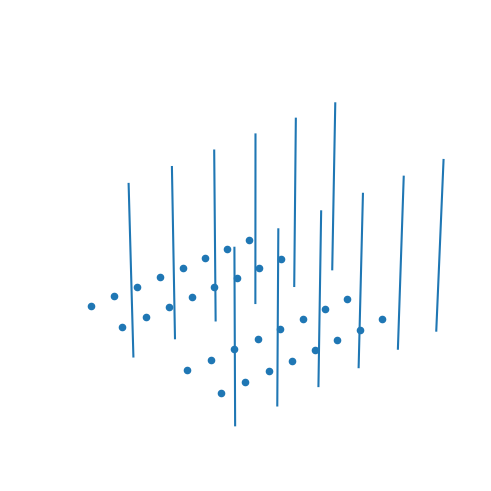

update_animation (generic function with 1 method)

In [4]:
# Base figure
fig = figure()
ax = fig.add_subplot(projection="3d")
ax.set_proj_type("persp")
ax.view_init(elev=30, azim=230, roll=0)
ax.set_axis_off()

# Set axes limit
min_xlim, max_xlim = Inf, 0
min_ylim, max_ylim = Inf, 0
for crop in crops
    min_xlim, max_xlim = min(min_xlim, crop.pos[1]), max(max_xlim, crop.pos[1])
    min_ylim, max_ylim = min(min_ylim, crop.pos[2]), max(max_ylim, crop.pos[2])
end

# Plot crops
crops_pos = stack(crop -> crop.pos, crops)
crops_plot = ax.scatter(crops_pos[1,:], crops_pos[2,:], crops_pos[3,:], depthshade=false)

# Plot modules poles
panels_pos = stack(panel -> panel.pos, panels)
panels_width = stack(panel -> panel.width, panels)
for i in [-1, 1]
   ax.stem(
       panels_pos[1,:] + i * 0.5panels_width,
       panels_pos[2,:],
       panels_pos[3,:],
       basefmt=" ",
       markerfmt=" "
   )
end

# Initialize panels and their shadow
panel_polygons = Poly3DCollection([zeros(4,3) for _ in 1:length(panels)], color=COLOR_PANEL)
shadow_polygons = Poly3DCollection([zeros(4,3) for _ in 1:length(panels)], color=COLOR_SHADOW)
ax.add_collection3d(panel_polygons)
ax.add_collection3d(shadow_polygons)

function update_animation(t)
    sun = suns[t]

    updated_panel_vertices, updated_panel_shadow = [], []
    for panel in panels
        push!(
            updated_panel_vertices,
            
        )
    end
end

In [5]:
optimal_tilt_vecs = Vector{Any}(undef, length(suns))

optimal_total_power = Vector{Real}(undef, length(suns))
optimal_light_coverage = Vector{Real}(undef, length(suns))

vertical_policy_total_power = Vector{Real}(undef, length(suns))
vertical_policy_light_coverage = Vector{Real}(undef, length(suns))

horizontal_policy_total_power = Vector{Real}(undef, length(suns))
horizontal_policy_light_coverage = Vector{Real}(undef, length(suns))

classical_policy_total_power = Vector{Real}(undef, length(suns))
classical_policy_light_coverage = Vector{Real}(undef, length(suns))

crops_to_light = sum(crop -> 1 - Int(crop.to_shadow), crops)
for (t, sun) in enumerate(suns)
    # Optimal control policy
    optimal_tilt_vecs[t], is_crop_shadowed = control(sun, panels, crops, ALBEDO, GAMMA)
    optimal_total_power[t] = sum(panel_power(panel, sun, ALBEDO, optimal_tilt_vecs[t][i,:]) for (i, panel) in enumerate(panels))
    optimal_light_coverage[t] = sum(1 .- is_crop_shadowed) / crops_to_light

    # 180-deg tilt
    vertical_tilt_vecs = [u(π/2) for  _ in panels]
    vertical_policy_total_power[t] = sum(panel_power(panel, sun, ALBEDO, vertical_tilt_vecs[i]) for (i,panel) in enumerate(panels))
    vertical_policy_light_coverage[t] = 
        sum(1 - Int(f_is_crop_shadowed(panels, crop, sun, vertical_tilt_vecs)) for crop in crops) / crops_to_light

    # 30-deg tilt
    classical_tilt_vecs = [u(π/6) for _ in panels]
    classical_policy_total_power[t] = sum(panel_power(panel, sun, ALBEDO, classical_tilt_vecs[i]) for (i,panel) in enumerate(panels))
    classical_policy_light_coverage[t] = 
        sum(1 - Int(f_is_crop_shadowed(panels, crop, sun, classical_tilt_vecs)) for crop in crops) / crops_to_light

    # 0-deg tilt
    horizontal_tilt_vecs = [u(0) for _ in panels]
    horizontal_policy_total_power[t] = sum(panel_power(panel, sun, ALBEDO, horizontal_tilt_vecs[i]) for (i,panel) in enumerate(panels))
    horizontal_policy_light_coverage[t] = 
        sum(1 - Int(f_is_crop_shadowed(panels, crop, sun, horizontal_tilt_vecs)) for crop in crops) / crops_to_light
end

[Sun @ 2024-10-26 05:30:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 05:45:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:00:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:15:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:30:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:45:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:00:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:15:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:30:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:45:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 08:00:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 08:15:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 08:30:00] 

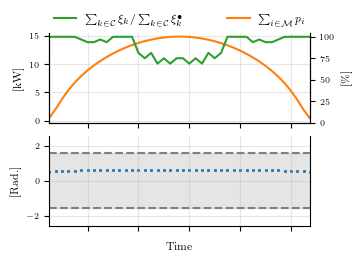

In [6]:
# Optimal control plotting
fig, axs = subplots(2, figsize=(3.5, 2.5), sharex=true, height_ratios=[1, 1])

function update_angles_tick(x, pos)
    if x == π/2
        return L"\pi/2"
    elseif x == -π/2
        return L"-\pi/2"
    end
end
ticker = matplotlib.ticker.FuncFormatter(update_angles_tick)

ax_right, ax_tilt = axs
ax_right.xaxis.set_major_formatter(formatter)
ax_right.xaxis.set_major_locator(locator)

ax_left = ax_right.twinx()
ax_right.plot(times, 1e-3optimal_total_power, color="tab:orange", label=L"\sum_{i \in \mathcal{M}} p_i")
ax_left.plot(
    times, 1e2optimal_light_coverage, 
    color="tab:green", label=L"\sum_{k \in \mathcal{C}} \xi_k / \sum_{k \in \mathcal{C}} \xi^\bullet_k"
)

ax_tilt.xaxis.set_major_formatter(ticker)
ax_tilt.set_xlabel("Time")
ax_tilt.set_ylabel("[Rad.]")
ax_tilt.set_xlim(times[1], times[end])
ax_tilt.set_ylim(-π/2 - 1, π/2 + 1)
ax_tilt.grid(true)

ax_right.set_ylabel("[kW]")
ax_right.grid(true)

ax_left.set_ylim(0, 105)
ax_left.set_ylabel(L"[\%]")

ax_right.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower right",
    borderaxespad=0, ncol=1
)
ax_left.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
    borderaxespad=0, ncol=1
)

tilt_points = stack(
    (time, angle(optimal_tilt_vecs[t][i,:]))
    for (t, time) in enumerate(times), (i, _) in enumerate(panels);
    dims=1
)
ax_tilt.scatter(tilt_points[:,1], tilt_points[:,2], s=0.5)
ax_tilt.fill_between(times, -π/2, π/2, color="gray", alpha=0.2)
ax_tilt.axhline(π/2, color="gray", ls="--")
ax_tilt.axhline(-π/2, color="gray", ls="--")

savefig("media/gamma-$(GAMMA).pdf")

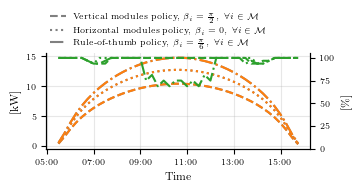

In [7]:
# Comparison policies
fig, ax_right = subplots(figsize=(3.5, 1.8))

ax_right.xaxis.set_major_formatter(formatter)
ax_right.xaxis.set_major_locator(locator)

ax_left = ax_right.twinx()

power_curves = [
    (vertical_policy_total_power, "--", L"\text{Vertical modules policy, $\beta_i = \frac{\pi}{2}, \ \forall i \in \mathcal{M}$}"),
    (horizontal_policy_total_power, ":", L"\text{Horizontal modules policy, $\beta_i = 0, \ \forall i \in \mathcal{M}$"),
    (classical_policy_total_power, "-.", L"\text{Rule-of-thumb policy, $\beta_i = \frac{\pi}{6}, \ \forall i \in \mathcal{M}$}")
]

light_curves = [
    (vertical_policy_light_coverage, "--"),
    (horizontal_policy_light_coverage, ":"),
    (classical_policy_light_coverage, "-.")
]

for (curve, ls, label) in power_curves
    ax_right.plot(times, 1e-3curve, color="gray", ls=ls, label=label)
    ax_right.plot(times, 1e-3curve, color="tab:orange", ls=ls)
end

for (curve, ls) in light_curves
    ax_left.plot(times, 1e2curve, color="tab:green", ls=ls)
end

ax_right.set_xlabel("Time")
ax_right.set_ylabel("[kW]")
ax_left.set_ylim(0, 105)
ax_left.set_ylabel(L"[\%]")

ax_right.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower right",
    borderaxespad=0, mode="expand", ncol=1, fontsize=6
)

ax_right.grid(true)
savefig("media/fix-tilt.pdf")

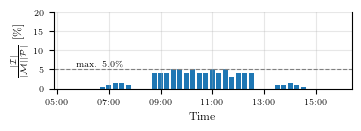

In [8]:
# Considered panel-crop pairs
spared_variable_ratio = Vector{Real}(undef, length(suns))
for (t, sun) in enumerate(suns)
    considered_panel_crop_pairs = sum(
        Int(can_panel_shadow_crop(panel, crop, sun, 100))
        for panel in panels, crop in crops
    )
    spared_variable_ratio[t] = considered_panel_crop_pairs / (length(crops) * length(panels))  
end

fig, ax = subplots(figsize=(3.5, 1.2))
ax.bar(times, 1e2spared_variable_ratio, linewidth=0, width=8e-3)
max_spared_variable_ratio = 1e2maximum(spared_variable_ratio)
ax.axhline(max_spared_variable_ratio, ls="--", lw=0.8, color="gray")
ax.text(times[2], 0.5 + max_spared_variable_ratio, "max. $(round(max_spared_variable_ratio))\\%", fontsize=6)

ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Time")
ax.set_ylabel(L"\frac{|\mathcal{I}|}{|\mathcal{M}||\mathcal{P}|} \ [\%]")

ax.set_ylim(0, 20)
ax.grid(true)

savefig("media/panel-crop-pairs.pdf")

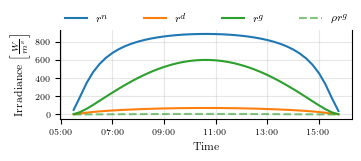

In [9]:
# Irradiance plot
normal = Vector{Real}(undef, length(suns))
diffuse = Vector{Real}(undef, length(suns))
ground = Vector{Real}(undef, length(suns))
for (t, sun) in enumerate(suns)
    normal[t] = sun.dni
    diffuse[t] = sun.dhi
    ground[t] = sun.ghi
end

fig, ax = subplots(figsize=(3.5,1.5))

ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.plot(times, normal, label=L"r^n")
ax.plot(times, diffuse, label=L"r^d")
ax.plot(times, ground, label=L"r^g")
ax.plot(times, ALBEDO*ground, ls="--", c="tab:green", alpha=0.6, label=L"\rho r^g")

ax.set_xlabel("Time")
ax.set_ylabel(L"\text{Irradiance $\left[\frac{W}{m^s}\right]$}")

ax.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower right",
    borderaxespad=0, mode="expand", ncol=4
)

ax.grid()
savefig("media/irradiance.pdf")
